In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA

sns.set()
warnings.filterwarnings('ignore')

In [157]:
train = pd.read_csv('input/train.csv')
electricity_prices = pd.read_csv('input/electricity_prices.csv')
forecast_weather = pd.read_csv('input/forecast_weather.csv')
gas_prices = pd.read_csv('input/gas_prices.csv')
historical_weather = pd.read_csv('input/historical_weather.csv')
client = pd.read_csv('input/client.csv')

In [102]:
county_map = {
    '59.4,24.7': 0,
    '58.8,22.7': 1,
    '59.4,27.2': 2,
    '58.8,25.7': 3,
    '58.8,26.2': 4,
    '59.4,26.2': 5,
    '58.8,23.7': 6,
    '58.5,24.2': 7,
    '58.2,27.2': 8,
    '58.8,24.7': 9,
    '58.5,22.7': 10,
    '58.5,26.7': 11,
    '59.1,24.7': 12,
    '57.9,26.2': 13,
    '58.5,25.2': 14,
    '57.9,27.2': 15
}

baseline_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', utc=True)

def extract_county_ids(df):
    df['coords'] = df['latitude'].astype(str) + ',' + df['longitude'].astype(str)
    df['county_id'] = df['coords'].map(county_map)
    return df.drop(['coords'], axis=1)
def extract_dates(df, lag=0):
    df['datetime'] = pd.to_datetime(df.datetime, utc=True) + pd.Timedelta(hours=lag)
    df['day_no'] = (df['datetime'] - baseline_date).dt.days
    df['week'] = df['day_no'] // 7
    df['hour'] = df['datetime'].apply(lambda x: x.hour)
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['weekday'] = df['datetime'].apply(lambda x: x.dayofweek)
    return df.drop('datetime', axis=1)
def add_column_prefixes(df, prefix):
    column_map = {}
    for col in df.columns:
        column_map[col] = prefix + col
    return df.rename(columns=column_map)

In [209]:
train2 = train.drop(['data_block_id', 'row_id', 'prediction_unit_id'], axis=1).dropna()
train2 = extract_dates(train2)

hw2 = historical_weather.drop('data_block_id', axis=1)
hw2 = extract_county_ids(hw2).dropna()
hw2 = extract_dates(hw2, lag=37)
hw2 = add_column_prefixes(hw2, 'hw_')

fw2 = forecast_weather[forecast_weather['hours_ahead'] == 1]
fw2 = fw2.drop(['data_block_id'], axis=1).dropna()
fw2 = fw2.rename(columns={'origin_datetime': 'datetime'})
fw2 = extract_county_ids(fw2).dropna()
fw2 = extract_dates(fw2, lag=24)
fw2 = add_column_prefixes(fw2, 'fw1_')

fw18 = forecast_weather[forecast_weather['hours_ahead'] == 18]
fw18 = fw18.drop(['data_block_id'], axis=1).dropna()
fw18 = fw18.rename(columns={'origin_datetime': 'datetime'})
fw18 = extract_county_ids(fw18).dropna()
fw18 = extract_dates(fw18, lag=24)
fw18 = add_column_prefixes(fw18, 'fw18_')

fw30 = forecast_weather[forecast_weather['hours_ahead'] == 30]
fw30 = fw30.drop(['data_block_id'], axis=1).dropna()
fw30 = fw30.rename(columns={'origin_datetime': 'datetime'})
fw30 = extract_county_ids(fw30).dropna()
fw30 = extract_dates(fw30, lag=24)
fw30 = add_column_prefixes(fw30, 'fw30_')

fw48 = forecast_weather[forecast_weather['hours_ahead'] == 48]
fw48 = fw48.drop(['data_block_id'], axis=1).dropna()
fw48 = fw48.rename(columns={'origin_datetime': 'datetime'})
fw48 = extract_county_ids(fw48).dropna()
fw48 = extract_dates(fw48, lag=24)
fw48 = add_column_prefixes(fw48, 'fw48_')

gp2 = gas_prices.drop(['origin_date', 'data_block_id'], axis=1)
gp2 = gp2.rename(columns={'forecast_date': 'datetime'})
gp2 = extract_dates(gp2, lag=48)
gp2 = add_column_prefixes(gp2, 'gp_')

ep2 = electricity_prices.drop(['origin_date', 'data_block_id'], axis=1)
ep2 = ep2.rename(columns={'forecast_date': 'datetime'})
ep2 = extract_dates(ep2, lag=48)
ep2 = add_column_prefixes(ep2, 'ep_')

client2 = client.rename(columns={'date': 'datetime'})
client2 = extract_dates(client2, lag=48)
client2 = add_column_prefixes(client2, 'cl_')

In [210]:
train3 = pd.merge(train2, gp2, 
                  how='left', 
                  left_on=['weekday', 'week'], 
                  right_on = ['gp_weekday', 'gp_week'])
train3 = pd.merge(train3, ep2, 
                  how='left', 
                  left_on=['weekday', 'week', 'hour'], 
                  right_on = ['ep_weekday', 'ep_week', 'ep_hour'])
train3 = pd.merge(train3, fw2, 
                  how='left', 
                  left_on=['county','weekday', 'week'], 
                  right_on = ['fw1_county_id','fw1_weekday', 'fw1_week'])
train3 = pd.merge(train3, fw48, 
                  how='left', 
                  left_on=['county','weekday', 'week'], 
                  right_on = ['fw48_county_id','fw48_weekday', 'fw48_week'])
train3 = pd.merge(train3, fw18, 
                  how='left', 
                  left_on=['county','weekday', 'week'], 
                  right_on = ['fw18_county_id','fw18_weekday', 'fw18_week'])
train3 = pd.merge(train3, fw30, 
                  how='left', 
                  left_on=['county','weekday', 'week'], 
                  right_on = ['fw30_county_id','fw30_weekday', 'fw30_week'])
hw3 = hw2.groupby(['hw_county_id', 'hw_weekday', 'hw_week', 'hw_hour']).mean()
train3 = pd.merge(train3, hw3,
                   how='left', 
                  left_on=['county','weekday', 'week', 'hour'], 
                  right_on = ['hw_county_id','hw_weekday', 'hw_week', 'hw_hour'])
print(train3.shape)
train3 = train3.dropna()
print(train3.shape)
train3 = pd.merge(train3, client2, 
                  how='left', 
                  left_on=['weekday', 'week', 'is_business', 'product_type', 'county'], 
                  right_on = ['cl_weekday', 'cl_week', 'cl_is_business', 'cl_product_type', 'cl_county'])
train3 = train3.dropna()
train3.shape

(2017824, 129)
(2011700, 129)


(2008918, 140)

In [211]:
data_cols = [
    'county',
    'is_business', 
    'product_type',
    'is_consumption',
    # 'day_no', 
    'week', 
    'hour', 
    'month', 
    'weekday', 
    'cl_eic_count',
    'cl_installed_capacity',
    'gp_lowest_price_per_mwh',
    # 'gp_highest_price_per_mwh',
    'ep_euros_per_mwh',
    # 'fw1_latitude', 
    # 'fw1_longitude',
    # 'fw1_temperature', 
    # 'fw1_dewpoint', 
    # 'fw1_cloudcover_high',
    # 'fw1_cloudcover_low', 
    # 'fw1_cloudcover_mid', 
    'fw1_cloudcover_total',
    # 'fw1_10_metre_u_wind_component', 
    # 'fw1_10_metre_v_wind_component',
    # 'fw1_direct_solar_radiation',
    # 'fw1_surface_solar_radiation_downwards', 
    # 'fw1_snowfall',
    # 'fw1_total_precipitation',
    # 'fw48_temperature', 
    # 'fw48_dewpoint', 
    # 'fw48_cloudcover_high',
    # 'fw48_cloudcover_low', 
    # 'fw48_cloudcover_mid', 
    # 'fw48_cloudcover_total',
    'fw48_10_metre_u_wind_component', 
    'fw48_10_metre_v_wind_component',
    # 'fw48_direct_solar_radiation',
    # 'fw48_surface_solar_radiation_downwards', 
    # 'fw48_snowfall',
    # 'fw48_total_precipitation',
    # 'fw18_temperature', 
    # 'fw18_dewpoint', 
    # 'fw18_cloudcover_high',
    # 'fw18_cloudcover_low', 
    # 'fw18_cloudcover_mid', 
    # 'fw18_cloudcover_total',
    # 'fw18_10_metre_u_wind_component', 
    # 'fw18_10_metre_v_wind_component',
    # 'fw18_direct_solar_radiation',
    # 'fw18_surface_solar_radiation_downwards', 
    'fw18_snowfall',
    # 'fw18_total_precipitation',
    # 'fw30_temperature', 
    'fw30_dewpoint', 
    # 'fw30_cloudcover_high',
    # 'fw30_cloudcover_low', 
    # 'fw30_cloudcover_mid', 
    # 'fw30_cloudcover_total',
    # 'fw30_10_metre_u_wind_component', 
    # 'fw30_10_metre_v_wind_component',
    # 'fw30_direct_solar_radiation',
    # 'fw30_surface_solar_radiation_downwards', 
    # 'fw30_snowfall',
    # 'fw30_total_precipitation',
    'hw_temperature', 
    # 'hw_dewpoint',
    'hw_rain', 
    # 'hw_snowfall', 
    'hw_surface_pressure', 
    # 'hw_cloudcover_total',
    # 'hw_cloudcover_low', 
    # 'hw_cloudcover_mid', 
    # 'hw_cloudcover_high',
    'hw_windspeed_10m', 
    # 'hw_winddirection_10m', 
    # 'hw_shortwave_radiation',
    # 'hw_direct_solar_radiation', 
    'hw_diffuse_radiation'
]
train4 = train3[data_cols + ['target']]

In [212]:
X, X_test, y, y_test= train_test_split(train4[data_cols], train4['target'], test_size=.2, random_state=40)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=40)

data = pd.DataFrame()
data['features'] = data_cols
data['VIF'] = [variance_inflation_factor(X_train, i).round(1) for i in range(train4[data_cols].shape[1])]
f_scores, p_scores = f_regression(X_train, y_train)
data['Fscores'] = f_scores.round(0)
data['Pscores'] = p_scores.round(5)
data = data.sort_values(by='Fscores', ascending=False)
data.head(50)

,features,VIF,Fscores,Pscores
9,cl_installed_capacity,4.0,703893.0,0.00000
8,cl_eic_count,3.8,112998.0,0.00000
3,is_consumption,2.0,52656.0,0.00000
2,product_type,4.7,37989.0,0.00000
1,is_business,2.8,32792.0,0.00000
0,county,3.5,11597.0,0.00000
21,hw_diffuse_radiation,2.5,2934.0,0.00000
4,week,12.0,1631.0,0.00000
7,weekday,3.4,573.0,0.00000
17,hw_temperature,6.3,561.0,0.00000


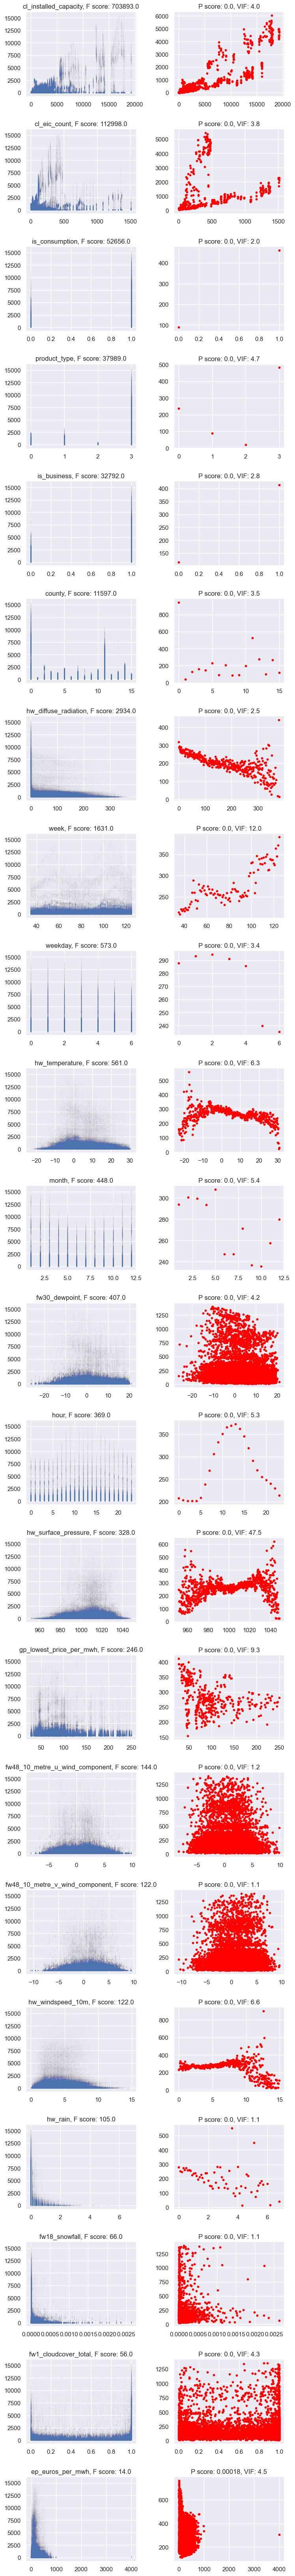

In [213]:
n = len(data_cols)
fig, axs = plt.subplots(ncols=2, nrows=n, figsize=(8, 3 * n))
fig.tight_layout(pad=3.0)

for i in range(data.shape[0]):
    col = data['features'].iloc[i]
    g = train4.groupby(col)['target'].agg('mean')
    axs[i, 0].scatter(train4[col], train4['target'], s=1, alpha=.002)
    axs[i, 0].title.set_text(col + ', F score: ' + str(data['Fscores'].iloc[i]))
    axs[i, 1].scatter(g.index, g, s=10, color='red');
    axs[i, 1].title.set_text('P score: ' + str(data['Pscores'].iloc[i]) + ', VIF: ' + str(data['VIF'].iloc[i]) )

In [32]:
params = {'max_depth': [15, 20], 
          'min_samples_leaf': [3],
         'n_estimators': [200, 300]}
model = RandomForestRegressor()
gs = GridSearchCV(estimator=model, 
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           verbose=2,
                           cv=3)
gs.fit(X_train[:10000], y_train[:10000])
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time=  12.3s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time=  10.6s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time=  10.9s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=300; total time=  18.3s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=300; total time=  18.4s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=300; total time=  16.4s
[CV] END .max_depth=20, min_samples_leaf=3, n_estimators=200; total time=  11.4s
[CV] END .max_depth=20, min_samples_leaf=3, n_estimators=200; total time=  11.6s
[CV] END .max_depth=20, min_samples_leaf=3, n_estimators=200; total time=  11.7s
[CV] END .max_depth=20, min_samples_leaf=3, n_estimators=300; total time=  17.2s
[CV] END .max_depth=20, min_samples_leaf=3, n_estimators=300; total time=  16.8s
[CV] END .max_depth=20, min_samples_leaf=3, n_est

In [35]:
model = RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_estimators=200)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_estimators=200)

MAE: training set
32.27745729169591
MAE: validation set
36.581946954716564


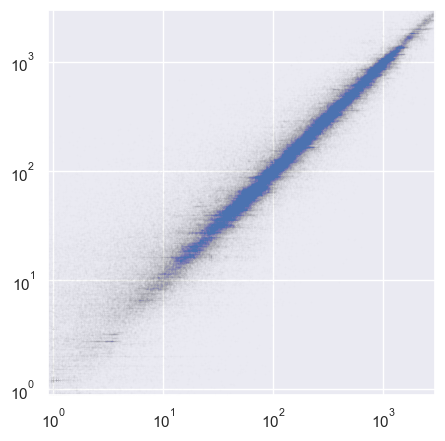

In [42]:
y_predict_train = model.predict(X_train)
y_predict_valid = model.predict(X_valid)
print('MAE: training set')
print(mean_absolute_error(y_train, y_predict_train))
print('MAE: validation set')
print(mean_absolute_error(y_valid, y_predict_valid))
plt.figure(figsize=(5,5))
plt.xscale(value='log')
plt.xlim(0, 3000)
plt.yscale(value='log')
plt.ylim(0, 3000)
plt.scatter(y_valid, y_predict_valid, s=1, alpha=.002);

In [203]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': [50],  
              'max_depth': [2, 5, 13], 
              'min_samples_leaf': [3, 5, 8],
              'learning_rate': [.1],
             'subsample': [.8, 1]} 
model = GradientBoostingRegressor()
gs = GridSearchCV(estimator=model, 
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           verbose=2,
                           cv=3)
gs.fit(X_train[:10000], y_train[:10000])
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=3, n_estimators=50, subsample=0.8; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=3, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=3, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=3, n_estimators=50, subsample=1; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=3, n_estimators=50, subsample=1; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=3, n_estimators=50, subsample=1; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=5, n_estimators=50, subsample=0.8; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=2, min_samples_leaf=5, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=2, min_samp

In [219]:
model = GradientBoostingRegressor(max_depth=13, min_samples_leaf=3, n_estimators=50, learning_rate=.1, subsample=.8)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=13, min_samples_leaf=3, n_estimators=50,
                          subsample=0.8)

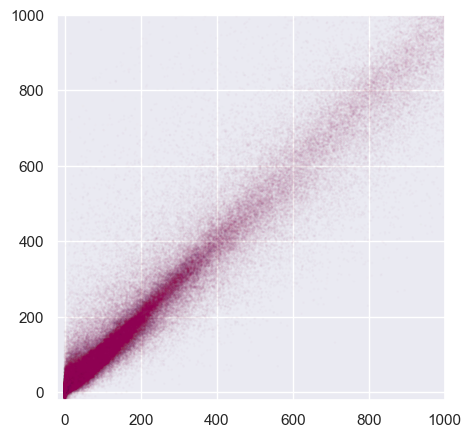

In [249]:
# y_predict_train = model.predict(X_train)
# y_predict_valid = model.predict(X_valid)
# print('MAE: training set')
# print(mean_absolute_error(y_train, y_predict_train))
# print('MAE: validation set')
# print(mean_absolute_error(y_valid, y_predict_valid))
plt.figure(figsize=(5,5))
plt.xlim(-20, 1000)
plt.ylim(-20, 1000)
plt.scatter(y_valid, y_predict_valid, s=1, alpha=.01, cmap='PiYG', c=X_valid['cl_eic_count']);

In [233]:
X_valid.head(2)

,county,is_business,product_type,is_consumption,week,hour,month,weekday,cl_eic_count,cl_installed_capacity,...,fw1_cloudcover_total,fw48_10_metre_u_wind_component,fw48_10_metre_v_wind_component,fw18_snowfall,fw30_dewpoint,hw_temperature,hw_rain,hw_surface_pressure,hw_windspeed_10m,hw_diffuse_radiation
44396,14,1,1,0,37,3,9,5,17.0,505.1,...,0.821100,-3.129395,-2.256853,0.0,3.482935,10.8,0.0,1017.4,3.055556,181.0
1335824,5,0,1,0,95,2,11,2,51.0,530.9,...,0.999993,-2.014209,1.898419,0.0,5.265405,6.3,0.0,1008.6,2.138889,85.0


MAE: training set
369.97871719983067
MAE: validation set
368.6310416204706


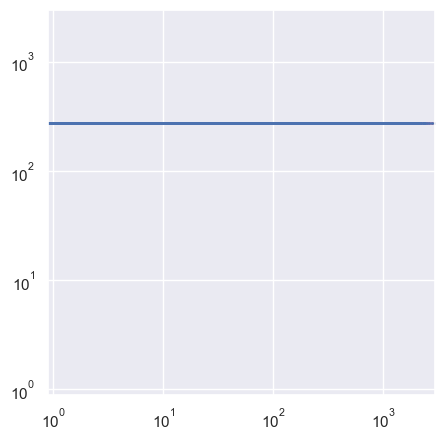

In [51]:
y_predict_train = y_train - y_train + y_train.mean()
y_predict_valid = y_valid - y_valid + y_train.mean()
print('MAE: training set')
print(mean_absolute_error(y_train, y_predict_train))
print('MAE: validation set')
print(mean_absolute_error(y_valid, y_predict_valid))
plt.figure(figsize=(5,5))
plt.xscale(value='log')
plt.xlim(0, 3000)
plt.yscale(value='log')
plt.ylim(0, 3000)
plt.scatter(y_valid, y_predict_valid, s=1, alpha=.002);